In [ ]:
pip install ctgan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.2 MB/s eta 0:00:00


In [ ]:
pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata





In [ ]:
df=pd.read_excel("/content/Combined dataset-malocclusion.xlsx")

In [ ]:
df.head(2)

,AGE,GENDER,RT PATTERN,RT FRC,LT PATTERN,LT FRC,Class/Group
0,23,F,L,38,L,20,Group I
1,16,M,W,0,W,0,Group I


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AGE          604 non-null    int64 
 1   GENDER       604 non-null    object
 2   RT PATTERN   604 non-null    object
 3   RT FRC       604 non-null    int64 
 4   LT PATTERN   604 non-null    object
 5   LT FRC       604 non-null    object
 6   Class/Group  604 non-null    object
dtypes: int64(2), object(5)
memory usage: 33.2+ KB


In [ ]:
obj=df.select_dtypes(include='object')

In [ ]:
for i in obj.columns:
  print(i,':',obj[i].unique())

GENDER : ['F' 'M']
RT PATTERN : ['L' 'W' 'A']
LT PATTERN : ['L' 'W' 'A']
LT FRC : [20 0 23 57 54 31 64 52 38 11 12 45 47 35 40 42 43 41 15 30 39 48 56 68 24
 67 60 69 53 10 71 70 65 62 59 72 46 17 9 28 27 6 7 5 25
 "'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''" 4 34 29
 37 44 51 55 32 33 16 49 14 8 50]
Class/Group : ['Group I' 'Group II' 'Group III']


In [ ]:
df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
df['RT PATTERN'] = df['RT PATTERN'].map({'L': 0, 'W': 1, 'A': 2})
df['LT PATTERN'] = df['LT PATTERN'].map({'L': 0, 'W': 1, 'A': 2})
df['Class/Group'] = df['Class/Group'].map({'Group I': 0, 'Group II': 1, 'Group III': 2})

In [ ]:
df.head(2)

,AGE,GENDER,RT PATTERN,RT FRC,LT PATTERN,LT FRC,Class/Group
0,23,0,0,38,0,20,0
1,16,1,1,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AGE          604 non-null    int64 
 1   GENDER       604 non-null    int64 
 2   RT PATTERN   604 non-null    int64 
 3   RT FRC       604 non-null    int64 
 4   LT PATTERN   604 non-null    int64 
 5   LT FRC       604 non-null    object
 6   Class/Group  604 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 33.2+ KB


In [ ]:
# rows that cannot be converted to numeric
bad_rows = df[pd.to_numeric(df['LT FRC'], errors='coerce').isna() & df['LT FRC'].notna()]

print(bad_rows)


     AGE  GENDER  RT PATTERN  RT FRC  LT PATTERN  \
229   21       0           1       0           1   

                                                LT FRC  Class/Group  
229  ''''''''''''''''''''''''''''''''''''''''''''''...            1  


In [ ]:
bad_values = df['LT FRC'][pd.to_numeric(df['LT FRC'], errors='coerce').isna()].unique()
print(bad_values)

["'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''"]


In [ ]:
# Drop the row where 'LT FRC' is not numeric
df = df[pd.to_numeric(df['LT FRC'], errors='coerce').notna()]


In [ ]:
df['LT FRC'] = pd.to_numeric(df['LT FRC'], errors='coerce')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 603 entries, 0 to 603
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AGE          603 non-null    int64
 1   GENDER       603 non-null    int64
 2   RT PATTERN   603 non-null    int64
 3   RT FRC       603 non-null    int64
 4   LT PATTERN   603 non-null    int64
 5   LT FRC       603 non-null    int64
 6   Class/Group  603 non-null    int64
dtypes: int64(7)
memory usage: 37.7 KB


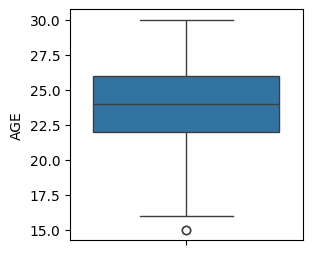

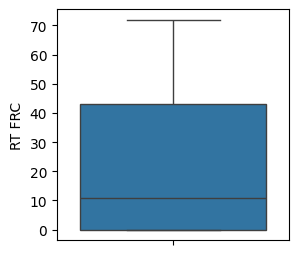

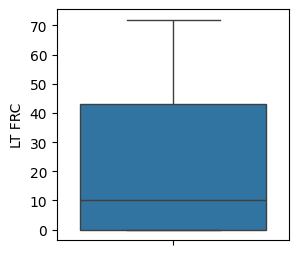

In [ ]:
iqr=['AGE','RT FRC','LT FRC']

for i in iqr:
  plt.figure(figsize=(3,3))
  sns.boxplot(df[i])
  plt.show()

In [ ]:
input=df.drop(['Class/Group'],axis=1)
output=df['Class/Group']

In [ ]:
xtr,xte,ytr,ye=train_test_split(input,output,test_size=0.2,random_state=42)

In [ ]:
train_real = pd.concat([xtr, ytr], axis=1)

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train_real)

# Step 2: Initialize CTGANSynthesizer with metadata
ctgan = CTGANSynthesizer(metadata=metadata, epochs=300)

# Step 3: Fit on your real training data
ctgan.fit(train_real)

# Step 4: Generate synthetic data
synthetic_data = ctgan.sample(200)






/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [ ]:
metadata

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "AGE": {
            "sdtype": "numerical"
        },
        "GENDER": {
            "sdtype": "categorical"
        },
        "RT PATTERN": {
            "sdtype": "categorical"
        },
        "RT FRC": {
            "sdtype": "numerical"
        },
        "LT PATTERN": {
            "sdtype": "categorical"
        },
        "LT FRC": {
            "sdtype": "numerical"
        },
        "Class/Group": {
            "sdtype": "categorical"
        }
    }
}

In [ ]:
xtr_aug = synthetic_data.drop('Class/Group', axis=1)
ytr_aug = synthetic_data['Class/Group']

In [ ]:
pd.DataFrame(xtr).shape

(482, 6)

In [ ]:
pd.DataFrame(xtr_aug).shape

(200, 6)

In [ ]:
pd.DataFrame(xtr_aug)

,AGE,GENDER,RT PATTERN,RT FRC,LT PATTERN,LT FRC
0,23,0,0,5,1,39
1,30,1,1,62,0,27
2,29,1,0,60,0,21
3,24,0,1,63,1,39
4,29,1,0,72,1,56
...,...,...,...,...,...,...
195,23,0,0,5,1,72
196,27,1,1,37,0,72
197,22,1,0,72,0,33
198,19,1,1,5,1,72


In [ ]:

xtr_final = pd.concat([xtr, xtr_aug], ignore_index=True)
ytr_final = pd.concat([ytr, ytr_aug], ignore_index=True)


In [ ]:
pd.DataFrame(xtr_final).shape

(682, 6)

In [ ]:
rf=RandomForestClassifier()
rf.fit(xtr_final,ytr_final)
rf_pred=rf.predict(xte)
print(classification_report(ye,rf_pred))
rf_accuracy=accuracy_score(ye,rf_pred)
print(rf_accuracy)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        44
           1       0.51      0.46      0.49        39
           2       0.43      0.47      0.45        38

    accuracy                           0.58       121
   macro avg       0.57      0.57      0.57       121
weighted avg       0.58      0.58      0.58       121

0.5785123966942148


In [ ]:
xgb=XGBClassifier()
xgb.fit(xtr_final,ytr_final)
xgb_pred=xgb.predict(xte)
print(classification_report(ye,xgb_pred))
xgb_accuracy=accuracy_score(ye,xgb_pred)
print("accuracy of xgb :", xgb_accuracy)

              precision    recall  f1-score   support

           0       0.92      0.77      0.84        44
           1       0.47      0.38      0.42        39
           2       0.42      0.58      0.49        38

    accuracy                           0.59       121
   macro avg       0.60      0.58      0.58       121
weighted avg       0.62      0.59      0.59       121

accuracy of xgb : 0.5867768595041323


In [ ]:
svm=SVC()
svm.fit(xtr_final,ytr_final)
svm_pred=svm.predict(xte)
print(classification_report(ye,svm_pred))
svm_accuracy=accuracy_score(ye,svm_pred)
print("accuracy of svm :", svm_accuracy)

              precision    recall  f1-score   support

           0       0.66      0.86      0.75        44
           1       0.00      0.00      0.00        39
           2       0.41      0.68      0.51        38

    accuracy                           0.53       121
   macro avg       0.36      0.52      0.42       121
weighted avg       0.37      0.53      0.43       121

accuracy of svm : 0.5289256198347108


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Starting With the HyperParameters

In [ ]:
xgb_param_grid = {
    "n_estimators": [50, 80, 100, 130, 150, 200],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.05, 0.1, 0.2],
    "gamma": [0, 0.1, 0.2],
    "min_child_weight": [1, 2, 3]
}

xgs=GridSearchCV(xgb,param_grid=xgb_param_grid,cv=5,verbose=2)
xgs.fit(xtr_final,ytr_final)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.3s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=80; total time=   0.1s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimat

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': [50, 80, 100, 130, 150, 200]},
             verbose=2)

In [ ]:
print(xgs.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)


In [ ]:
xgs.best_score_

np.float64(0.5071275225418634)